# Notebook details

In [1]:
def setup_notebook(fix_python_path=True, reduce_margins=True, plot_inline=True):
    if reduce_margins:
        # Reduce side margins of the notebook
        from IPython.core.display import display, HTML
        display(HTML("<style>.container { width:100% !important; }</style>"))

    if fix_python_path:
        # add egosocial to the python path
        import os, sys
        sys.path.extend([os.path.dirname(os.path.abspath('.'))])

    if plot_inline:
        # Plots inside cells
        %matplotlib inline
    
    global __file__
    __file__ = 'Notebook'

setup_notebook()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


# Imports and Constants Definition

In [2]:
# !/usr/bin/env python
# -*- coding: utf-8 -*-

import argparse
from collections import defaultdict
import functools
import itertools
import json
import logging
import math
import os
import pprint
import sys

from IPython.display import SVG

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import scipy

SHARED_SEED = 42
np.random.seed(SHARED_SEED)

from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import LeavePGroupsOut
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import compute_class_weight

import keras
from keras import backend as K
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import LearningRateScheduler

import egosocial
import egosocial.config
from egosocial.core.attributes import AttributeSelector
from egosocial.core.models import create_model_top_down
from egosocial.core.models import create_model_bottom_up
from egosocial.core.models import create_model_independent_outputs
from egosocial.utils.filesystem import create_directory 
from egosocial.utils.filesystem import check_directory
from egosocial.utils.keras.autolosses import AutoMultiLossWrapper
from egosocial.utils.keras.backend import limit_gpu_allocation_tensorflow
from egosocial.utils.keras.callbacks import PlotLearning
from egosocial.utils.keras.metrics import precision
from egosocial.utils.keras.metrics import recall
from egosocial.utils.keras.metrics import fmeasure
from egosocial.utils.keras.processing import TimeSeriesDataGenerator
from egosocial.utils.logging import setup_logging
from egosocial.utils.sklearn.model_selection import StratifiedGroupShuffleSplitWrapper
from egosocial.utils.misc import RELATIONS, DOMAINS
from egosocial.utils.misc import LabelExpander
from egosocial.utils.misc import decode_prediction
from egosocial.utils.misc import relation_to_domain_vec

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Limit GPU memory allocation with Tensorflow

In [3]:
limit_memory = True
if limit_memory and K.backend() == 'tensorflow':
    memory_ratio = 0.3
    limit_gpu_allocation_tensorflow(memory_ratio)

# Fake main

In [4]:
 def main(*fake_args):
    entry_msg = 'Train model for social relations classification in egosocial photo-streams.'
    parser = argparse.ArgumentParser(description=entry_msg)

    parser.add_argument('--dataset_path', required=True,
                        help='Path to file containing the input data and labels information merged.')

    parser.add_argument('--features_dir', required=True,
                        help='Directory where the extracted features are stored.')
    
    parser.add_argument('--reuse_model', required=False,
                        action='store_true',
                        help='Use precomputed model if available.')

    parser.add_argument('--save_model', required=False,
                        action='store_true',
                        help='Save model to disk.')

    parser.add_argument('--save_stats', required=False,
                        action='store_true',
                        help='Save statistics to disk.')

    parser.add_argument('--epochs', required=False, type=int,
                        default=30,
                        help='Max number of epochs.')

    parser.add_argument('--batch_size', required=False, type=int,
                        default=32,
                        help='Batch size.')
    
    parser.add_argument('--lr', required=False, type=float,
                        default=0.001,
                        help='Initial learning rate.')
    
    if not os.path.isdir(egosocial.config.TMP_DIR):
        os.mkdir(egosocial.config.TMP_DIR)

    setup_logging(egosocial.config.LOGGING_CONFIG,
                  log_dir=egosocial.config.LOGS_DIR)
    
    # TODO: implement correctly
    args = parser.parse_args(*fake_args)

    return args

# Helper functions

In [5]:
def parse_day(image_path):
    image_name = os.path.basename(image_path)
    # a valid image follows the day_hour_x.ext format
    day_hour_rest = image_name.split('_')
    
    if len(day_hour_rest) == 3:
        # day is the first item
        return day_hour_rest[0]
    else:
        # day isn't available
        return ''
    
def load_dataset_defition(dataset_path, include_day=True):
    with open(dataset_path, 'r') as json_file:
        dataset_def = json.load(json_file)

    # flatten the segments structure
    samples = pd.DataFrame(list(itertools.chain(*dataset_def)))
    
    if include_day:
        samples['day'] = samples['global_image_path'].apply(parse_day)
    
    return samples

def load_features(features_path, data_frames):
    features = np.load(features_path)
    sequences_info = data_frames.groupby(['split', 'segment_id', 'group_id'])    

    feature_sequences = []
    for seq_id, group in sequences_info:
        feature_seq = features[group.index]
        feature_seq.shape = (feature_seq.shape[0], -1)
        feature_sequences.append(feature_seq)
    
    return np.asarray(feature_sequences)

def load_fields(data_frames, fields, valid_frames_idx=None):
    assert len(fields) > 0
    
    if valid_frames_idx is None:
        sequences_info = data_frames.groupby(['split', 'segment_id', 'group_id'])
    else:
        sequences_info = data_frames[valid_frames_idx].groupby(['split', 'segment_id', 'group_id'])
    
    fst_seq_frames = [group.index[0] for _, group in sequences_info]
    fields_data =  data_frames.iloc[fst_seq_frames][fields].values

    return [fields_data[:, field_idx] for field_idx in range(len(fields))]
            
def compute_class_frequency(y, index=None):
    if index:
        y =  y[index]
    _, counts = np.unique(y, return_counts=True)
    freq = counts / len(y)
    return freq

def compute_class_weight_labels(y, mode=None):
    if mode == 'both_fused':
        raise NotImplementedError('Class weights are not available in mode both_fused.')

    encoder = LabelExpander(mode=mode)
    y = encoder(y)

    class_weight = {}
    for y_type, y_data in y.items():
        data = list(np.argmax(y_data, axis=1))    
        classes = np.unique(data)
        weights = compute_class_weight('balanced', classes, data)
        class_weight[y_type] = dict(zip(classes, weights))
    
    return class_weight
                
class DimReductionTransformer(object):        

    def __init__(self, n_components, Q=32, normalize=True, random_state=None):
        # PCA configuration (number of components or min explained variance)
        self.pca_param = n_components
         # features quantization (smaller Q promotes sparsity)
        self.Q = Q
        self.normalize = normalize
        self.random_state = sklearn.utils.check_random_state(random_state)
        
        self._scaler = None
        self._pca = None
        
        self._log = logging.getLogger(self.__class__.__name__)
        
    def fit(self, x):
        # reset state
        self._scaler = None
        self._pca = None        
    
        if self.normalize:
            if self.Q: # quantization requires data in range [0, 1] 
                self._scaler = Normalizer(norm='l2')
            else:
                self._scaler = StandardScaler()
            
            self._log.debug('Fitting data normalization.')            
            x = self._scaler.fit_transform(x)            
            
        if self.Q:
            # small Q promotes sparsity
            x = np.floor(self.Q * x)

        self._log.debug('Fitting PCA.')        
        assert self.pca_param > 0     
        # compute pca from scratch
        if 0 < self.pca_param <= 1:
            # running pca with min explained variance takes much longer
            self._pca = PCA(self.pca_param, random_state=self.random_state)
        else:
            self._pca = PCA(self.pca_param, svd_solver='randomized', random_state=self.random_state)
        
        self._pca.fit(x)
        
    def transform(self, x):
        if self.normalize:
            self._log.debug('Applying data normalization')
            x = self._scaler.transform(x)

        if self.Q:
            # small Q promotes sparsity
            self._log.debug('Applying Q-sparsity Q={}'.format(self.Q))
            x = np.floor(self.Q * x)            

        explained_var = np.sum(self._pca.explained_variance_ratio_)
        n_components = self._pca.n_components_
        msg = 'Applying PCA with explained var {} dims {}'
        self._log.debug(msg.format(explained_var, n_components))
        # pca transformation
        x = self._pca.transform(x)

        return x

In [6]:
def custom_classification_report(y_true, y_pred, labels=None, target_names=None,
                                 sample_weight=None, digits=2,
                                 weighted=True):
    """Build a text report showing the main classification metrics
    Read more in the :ref:`User Guide <classification_report>`.
    Parameters
    ----------
    y_true : 1d array-like, or label indicator array / sparse matrix
        Ground truth (correct) target values.
    y_pred : 1d array-like, or label indicator array / sparse matrix
        Estimated targets as returned by a classifier.
    labels : array, shape = [n_labels]
        Optional list of label indices to include in the report.
    target_names : list of strings
        Optional display names matching the labels (same order).
    sample_weight : array-like of shape = [n_samples], optional
        Sample weights.
    digits : int
        Number of digits for formatting output floating point values
    Returns
    -------
    report : string
        Text summary of the precision, recall, F1 score for each class.
        The reported averages are a prevalence-weighted macro-average across
        classes (equivalent to :func:`precision_recall_fscore_support` with
        ``average='weighted'``).
        Note that in binary classification, recall of the positive class
        is also known as "sensitivity"; recall of the negative class is
        "specificity".
    Examples
    --------
    >>> y_true = [0, 1, 2, 2, 2]
    >>> y_pred = [0, 0, 2, 2, 1]
    >>> target_names = ['class 0', 'class 1', 'class 2']
    >>> print(custom_classification_report(y_true, y_pred, target_names=target_names))
                 precision    recall  f1-score   support
    <BLANKLINE>
        class 0       0.50      1.00      0.67         1
        class 1       0.00      0.00      0.00         1
        class 2       1.00      0.67      0.80         3
    <BLANKLINE>
    avg / total       0.70      0.60      0.61         5
    <BLANKLINE>
    """

    if labels is None:
        labels = sklearn.utils.multiclass.unique_labels(y_true, y_pred)
    else:
        labels = np.asarray(labels)

    if target_names is not None and len(labels) != len(target_names):
        warnings.warn(
            "labels size, {0}, does not match size of target_names, {1}"
            .format(len(labels), len(target_names))
        )

    last_line_heading = 'avg / total'

    if target_names is None:
        target_names = [u'%s' % l for l in labels]
    name_width = max(len(cn) for cn in target_names)
    width = max(name_width, len(last_line_heading), digits)

    headers = ["precision", "recall", "f1-score", "support"]
    head_fmt = u'{:>{width}s} ' + u' {:>9}' * len(headers)
    report = head_fmt.format(u'', *headers, width=width)
    report += u'\n\n'

    p, r, f1, s = sklearn.metrics.precision_recall_fscore_support(
        y_true, y_pred,
        labels=labels,
        average=None,
        sample_weight=sample_weight)

    row_fmt = u'{:>{width}s} ' + u' {:>9.{digits}f}' * 3 + u' {:>9}\n'
    rows = zip(target_names, p, r, f1, s)
    for row in rows:
        report += row_fmt.format(*row, width=width, digits=digits)

    report += u'\n'

    
    if weighted:
        s_weights = s
    else:
        s_weights = None
    # compute averages
    report += row_fmt.format(last_line_heading,
                             np.average(p, weights=s_weights),
                             np.average(r, weights=s_weights),
                             np.average(f1, weights=s_weights),
                             np.sum(s),
                             width=width, digits=digits)

    return report


def compute_stats(y, y_predicted, weighted=True):
    acc = sklearn.metrics.accuracy_score(y, y_predicted)
    confusion_matrix = sklearn.metrics.confusion_matrix(y, y_predicted)
    report = custom_classification_report(y, y_predicted, weighted=weighted, digits=4)

    return acc, confusion_matrix, report

def print_statistics(val_stats=None, test_stats=None, fdesc=sys.stdout):
    for description, stats in [('Validation set:', val_stats), (('Test set:', test_stats))]:
        
        if stats is not None:
            print(description, file=fdesc)
            accuracy, confusion_matrix, report = stats
            print('Confusion matrix:', file=fdesc)
            print(confusion_matrix, file=fdesc)
            print(file=fdesc)
            print(report, file=fdesc)
            print('Accuracy: {:.3f}'.format(accuracy), file=fdesc)
            print('------------------------------------------------', file=fdesc)

In [7]:
class SocialClassifierWithPreComputedFeatures:
    
    def __init__(self, dataset_path, features_dir, test_size=0.2, k_fold_splits=10, val_size=None, n_components=50, Q=32, seed=42):
        self.dataset_path = dataset_path
        self.features_dir = features_dir
        self.test_size = test_size
        self.k_fold_splits = k_fold_splits
        self.val_size = val_size if val_size else 1.0 / k_fold_splits
        self.n_components = n_components
        self.Q = Q
        self.seed = seed

        self._frames = None
        self._grouped_frames = None
        self._labels = None
        self._users = None
        self._attribute_features = None
        self._train_idx = None
        self._test_idx = None
        self._k_train_val_idx = None
        
        self._log = logging.getLogger(self.__class__.__name__)

    def load_data(self):        
        # load dataset definition
        frames = load_dataset_defition(self.dataset_path, include_day=True)
        # filter labels with few samples
        valid_frames_idx = np.isin(frames['relation_label'], RELATIONS)

        self._frames = frames[valid_frames_idx]
        self._grouped_frames = self._frames.groupby(['split', 'segment_id', 'group_id'])

        # for each sequence get label, user, day of first frame
        self._labels, self._users, self._seq_days = load_fields(
            frames, ['relation_label', 'camera_user_name', 'day'], 
            valid_frames_idx=valid_frames_idx
        )
        
        self._init_features(self._frames)
        self._init_grouped_splits()
        self._dim_reduction = defaultdict(dict)

    def _init_features(self, valid_frames):
        attributes = sorted(next(os.walk(self.features_dir))[2])
        attributes = [attr for attr in attributes if attr.endswith('.npy')]

        # load features
        self._attribute_features = {}
        for attribute_file in attributes:
            attribute_name, ext = os.path.splitext(attribute_file)
            features_path = os.path.join(self.features_dir, attribute_file)
            self._attribute_features[attribute_name] = load_features(features_path, valid_frames)        
        
    def _init_stratified_splits(self):
        # define data splits
        # define train, test splits
        sss = StratifiedShuffleSplit(test_size=self.test_size, random_state=self.seed)
        y = self._labels
        self._train_idx, self._test_idx = next(sss.split(np.zeros(len(y)), y))  

        # define k-fold train splits
        skf = StratifiedKFold(n_splits=self.k_fold_splits, random_state=self.seed)
        y = np.array(y[self._train_idx])
        
        self._k_train_val_idx = []
        for t_idx, v_idx in skf.split(np.zeros(len(y)), y):
            self._k_train_val_idx.append((self._train_idx[t_idx], self._train_idx[v_idx]))

    def _init_grouped_splits(self):
        # define data splits
        # define train, test splits        
        criteria = np.array([ user + '_' + day for user, day in zip(self._users, self._seq_days) ])
        y, groups = helper._labels, criteria

        n_tries, group_size, epsilon = 1000, self.test_size, 0.025

        split_wrapper = StratifiedGroupShuffleSplitWrapper(
            GroupShuffleSplit(n_splits=n_tries, test_size=group_size, random_state=self.seed), 
            n_splits=1, 
            max_test_size=min(self.test_size + epsilon, 1.0), min_test_size=max(self.test_size - epsilon, 0.0)
        )
        self._train_idx, self._test_idx, train_test_score = next(split_wrapper.split(np.zeros(len(y)), y, groups, return_score=True))
        test_size = len(self._test_idx) / (len(self._train_idx) + len(self._test_idx))
        self._log.debug('Split train-test score: {:.3} real_test_size: {:.3}'.format(train_test_score, test_size))
        
        # define k-fold splits
        y, groups = y[self._train_idx], groups[self._train_idx]
        
        if self.k_fold_splits > 1:
            # k-fold strategy
            # search 50 times the number of splits, encourage diversity
            # double the epsilon (more flexible)
            n_tries, group_size, epsilon = self.k_fold_splits * 50, self.val_size, 0.05
        else:
            # holdout strategy
            # keep n_tries and epsilon same as train-test split
            group_size = self.val_size
        
        split_wrapper = StratifiedGroupShuffleSplitWrapper(
            GroupShuffleSplit(n_splits=n_tries, test_size=group_size, random_state=self.seed), 
            n_splits=self.k_fold_splits,
            max_test_size=min(self.val_size + epsilon, 1.0), min_test_size=max(self.val_size - epsilon, 0.0)
        )
        
        self._k_train_val_idx = []
        for k, (t_idx, v_idx, t_v_score) in enumerate(split_wrapper.split(np.zeros(len(y)), y, groups, return_score=True)):
            self._k_train_val_idx.append((self._train_idx[t_idx], self._train_idx[v_idx]))
            val_size = (1 - test_size) * len(v_idx) / (len(t_idx) + len(v_idx))
            self._log.debug('{}-fold split score: {:.3} real_val_size={:.3}'.format(k, t_v_score, val_size))            
            
    def list_attributes(self):
        # list attributes
        if self._attribute_features:
            return sorted(self._attribute_features.keys())
        else:
            return []
            
    def _get_split_idx(self, split, k_fold=None):
        assert split in ('train', 'test', 'val')
        if split == 'train':
            if k_fold is None:
                return self._train_idx
            else:
                assert 0 <= k_fold < self.k_fold_splits
                return self._k_train_val_idx[k_fold][0]

        if split == 'val':
            assert 0 <= k_fold < self.k_fold_splits
            return self._k_train_val_idx[k_fold][1]
        
        if split == 'test':
            return self._test_idx
        
    def get_k_train_val_split(self, selected_attributes, k_fold, preprocess_mask=None):
        assert 0 <= k_fold < self.k_fold_splits
        return self._get_train_test_val_split(selected_attributes, k_fold=k_fold, preprocess_mask=preprocess_mask)
        
    def get_train_test_split(self, selected_attributes, preprocess_mask=None):
        return self._get_train_test_val_split(selected_attributes, preprocess_mask=preprocess_mask)
    
    def _get_train_test_val_split(self, selected_attributes, k_fold=None, preprocess_mask=None):
        # get data splits composed by selected attributes only
        # preprocess the data

        # preconditions
        assert self._attribute_features is not None
        assert self._labels is not None
        assert len(selected_attributes) > 0 
        assert preprocess_mask is None or len(preprocess_mask) == len(selected_attributes)
        min_dim_for_pca = self.n_components
        
        if k_fold is None:
            train_idx, test_idx = self._get_split_idx('train'), self._get_split_idx('test')
            k_fold = -1 # see DimReductionTransformer init below
        else:
            assert 0 <= k_fold < self.k_fold_splits
            train_idx, test_idx = self._get_split_idx('train', k_fold), self._get_split_idx('val', k_fold)
            
        # preprocess each selected attribute individually
        train_features_list, test_features_list = [], []
        for attr_i, attr in enumerate(selected_attributes):            
            train_features = self._attribute_features[attr][train_idx]
            train_features = list(itertools.chain(*train_features))
            
            test_features = self._attribute_features[attr][test_idx]
            test_features = list(itertools.chain(*test_features))
            
            n_features = train_features[0].shape[-1]
            if preprocess_mask and preprocess_mask[attr_i]:
                self._log.debug('Preprocessing {}.'.format(attr))
                # initialize transformation for each attribute
                if min_dim_for_pca <= n_features:
                    # init transformation with different (fixed) seed for each fold
                    transformation = DimReductionTransformer(n_components=self.n_components, Q=self.Q, random_state=self.seed + k_fold)
                else:
                    transformation = MinMaxScaler()

                transformation.fit(train_features)
            
                train_features = transformation.transform(train_features)
                test_features = transformation.transform(test_features)
            else:
                self._log.debug('Skip preprocessing {}.'.format(attr))

            train_features_list.append(train_features)
            test_features_list.append(test_features)

        attr = selected_attributes[0]
        # create sequence structure for train
        train_features_fused = np.concatenate(train_features_list, axis=-1)
        train_seq_len = map(len, self._attribute_features[attr][train_idx])
        train_features_as_seqs = []
        offset = 0
        for seq_len in train_seq_len:        
            seq_range = range(offset, offset+seq_len)
            train_features_as_seqs.append(train_features_fused[seq_range])
            offset += seq_len
        
        # create sequence structure for testtrain
        test_features_fused = np.concatenate(test_features_list, axis=-1)
        test_seq_len = map(len, self._attribute_features[attr][test_idx])
        test_features_as_seqs = []
        offset = 0
        for seq_len in test_seq_len:        
            seq_range = range(offset, offset+seq_len)
            test_features_as_seqs.append(test_features_fused[seq_range])
            offset += seq_len
        
        return (train_features_as_seqs, self._labels[train_idx]), (test_features_as_seqs, self._labels[test_idx])
    
    def max_sequence_len(self):
        return self._grouped_frames.size().max()

# Configure Keras

In [8]:
def init_callbacks(output_mode, plot_stats=True, save_model=False, save_stats=False, stop_early=False, reduce_lr=False, figsize=None):
    callbacks = []

    training_dir = os.path.join(egosocial.config.TMP_DIR, 'training')
    create_directory(training_dir, 'Training')

    if save_model:
        checkpoint_path = os.path.join(training_dir,
                                       'weights.{epoch:02d}-{val_loss:.2f}.h5')
        checkpointer = ModelCheckpoint( 
            filepath=checkpoint_path, monitor='val_loss',
            save_best_only=True, period=5,
        )
        callbacks.append(checkpointer)

    if save_stats:
        metrics_path = os.path.join(training_dir,
                                    'metrics.csv')
        csv_logger = CSVLogger(metrics_path)
        callbacks.append(csv_logger)
        
    if reduce_lr:
        lr_handler = ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001
        )
        callbacks.append(lr_handler)
        
    if plot_stats:
        # more plots need more space
        if not figsize:
            if output_mode != 'both_splitted':
                figsize = (25, 5)
            else:
                figsize = (25, 13)

        plot_metrics = PlotLearning(update_step=5, figsize=figsize)
        callbacks.append(plot_metrics)
        
    if stop_early:
        stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, mode='auto')
        callbacks.append(stopper)
    
    return callbacks

def compile_model(
    model, 
    optimizer='adam', 
    loss='categorical_crossentropy', 
    loss_weights='auto',
    **kwargs
):
    # wrapper allows to train the loss weights
    model_wrapper = AutoMultiLossWrapper(model)
    model_wrapper.compile(optimizer=optimizer, loss=loss, 
                          loss_weights=loss_weights, **kwargs)

    return model_wrapper.model

In [9]:
BASE_DIR = os.path.join(egosocial.config.TMP_DIR, 'egocentric', 'datasets')

args = [
    "--dataset_path", os.path.join(BASE_DIR, 'merged_dataset.json'),
    "--features_dir", os.path.join(BASE_DIR, 'extracted_features'),
]

conf = main(args)

# Loading precomputed features and labels

In [10]:
helper = SocialClassifierWithPreComputedFeatures(
    conf.dataset_path, conf.features_dir, 
    test_size=0.2, 
    k_fold_splits=3, 
    val_size=0.2, 
    n_components=50, 
    Q=32,
    seed=SHARED_SEED
)

helper.load_data()

2018-04-14 22:18:23,169 - SocialClassifierWithPreComputedFeatures - DEBUG - Split train-test score: 0.0316 real_test_size: 0.193
2018-04-14 22:18:23,228 - SocialClassifierWithPreComputedFeatures - DEBUG - 0-fold split score: 0.0373 real_val_size=0.122
2018-04-14 22:18:23,228 - SocialClassifierWithPreComputedFeatures - DEBUG - 1-fold split score: 0.0631 real_val_size=0.125
2018-04-14 22:18:23,229 - SocialClassifierWithPreComputedFeatures - DEBUG - 2-fold split score: 0.0978 real_val_size=0.131


# Some statistics

In [11]:
stats = []
for user in np.unique(helper._users):
    user_labels = helper._labels[helper._users == user]
    unique_user_labels = np.unique(user_labels)
    stats.append({'User':user, '# samples': len(user_labels), '# labels:': len(unique_user_labels),  'labels' : unique_user_labels})
stats = pd.DataFrame(stats)
stats

,# labels:,# samples,User,labels
0,4,83,Alejandro,"[colleages, customer-staff, friends, leader-su..."
1,3,17,Eduardo,"[father-child, lovers/spouses, mother-child]"
2,9,195,Estefania,"[classmates, colleages, customer-staff, father..."
3,8,131,Gabriel,"[classmates, colleages, father-child, friends,..."
4,9,59,Marc,"[classmates, colleages, customer-staff, father..."
5,8,161,Maya,"[classmates, colleages, customer-staff, friend..."
6,6,43,Petia,"[colleages, customer-staff, friends, leader-su..."


# Select attributes (default all), prepare output

In [12]:
attribute_selector = AttributeSelector(helper.list_attributes())

# all / face / body / or single attribute (accept name substring, e.g. activity)
attributes_query = 'all'
# expand all / face / body / single attribute
selected_attributes = attribute_selector.filter(attributes_query)
print('Selected attribute(s): {}'.format(selected_attributes))

to_process = lambda attr : attr not in ('camera_user_age', 'camera_user_gender')
mask = [to_process(attr) for attr in selected_attributes]

Selected attribute(s): ['activity', 'body_age', 'body_clothing', 'body_gender', 'camera_user_age', 'camera_user_gender', 'distance', 'face_appearance', 'face_emotion', 'head_age', 'head_gender', 'head_pose']


# Prepare data

In [13]:
helper.Q = 32
helper.n_components = 50

In [14]:
k_fold=0
# prepare splits for selected attributes
#(k_x_train, k_y_train), (k_x_val, k_y_val) = helper.get_k_train_val_split(selected_attributes, k_fold=k_fold, preprocess_mask=mask)

(k_x_train, k_y_train), (k_x_val, k_y_val) = helper.get_train_test_split(selected_attributes, preprocess_mask=mask)

2018-04-14 22:18:23,269 - SocialClassifierWithPreComputedFeatures - DEBUG - Preprocessing activity.
2018-04-14 22:18:23,270 - DimReductionTransformer - DEBUG - Fitting data normalization.
2018-04-14 22:18:23,465 - DimReductionTransformer - DEBUG - Fitting PCA.
2018-04-14 22:18:24,389 - DimReductionTransformer - DEBUG - Applying data normalization
2018-04-14 22:18:24,487 - DimReductionTransformer - DEBUG - Applying Q-sparsity Q=32
2018-04-14 22:18:24,566 - DimReductionTransformer - DEBUG - Applying PCA with explained var 0.4863877296447754 dims 50
2018-04-14 22:18:24,632 - DimReductionTransformer - DEBUG - Applying data normalization
2018-04-14 22:18:24,662 - DimReductionTransformer - DEBUG - Applying Q-sparsity Q=32
2018-04-14 22:18:24,689 - DimReductionTransformer - DEBUG - Applying PCA with explained var 0.4863877296447754 dims 50
2018-04-14 22:18:24,710 - SocialClassifierWithPreComputedFeatures - DEBUG - Preprocessing body_age.
2018-04-14 22:18:24,713 - DimReductionTransformer - DEB

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/decomposition/pca.py:505: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ / total_var.sum()


2018-04-14 22:18:35,585 - DimReductionTransformer - DEBUG - Applying PCA with explained var nan dims 50
2018-04-14 22:18:35,713 - DimReductionTransformer - DEBUG - Applying data normalization
2018-04-14 22:18:35,766 - DimReductionTransformer - DEBUG - Applying Q-sparsity Q=32
2018-04-14 22:18:35,805 - DimReductionTransformer - DEBUG - Applying PCA with explained var nan dims 50
2018-04-14 22:18:35,841 - SocialClassifierWithPreComputedFeatures - DEBUG - Preprocessing face_emotion.
2018-04-14 22:18:35,845 - DimReductionTransformer - DEBUG - Fitting data normalization.
2018-04-14 22:18:36,242 - DimReductionTransformer - DEBUG - Fitting PCA.
2018-04-14 22:18:38,025 - DimReductionTransformer - DEBUG - Applying data normalization
2018-04-14 22:18:38,209 - DimReductionTransformer - DEBUG - Applying Q-sparsity Q=32
2018-04-14 22:18:38,366 - DimReductionTransformer - DEBUG - Applying PCA with explained var 0.9999830722808838 dims 50
2018-04-14 22:18:38,495 - DimReductionTransformer - DEBUG - Ap

# Parameters

In [15]:
n_train, n_val = len(k_x_train), len(k_x_val)
n_features = k_x_train[0].shape[-1]
max_timestep = helper.max_sequence_len()
batch_size = 64

print('Length of the largest sequence:', max_timestep)
print('Number of features:', n_features)
print('Number of samples fold={}. Training: {} / Validation {}'.format(k_fold, n_train, n_val))
print('Batch size: {}'.format(batch_size))

output_mode = 'both_splitted' # multi-loss domain-relation
#output_mode = 'domain' # domain only
#output_mode = 'relation' # relation only

print('Output mode: {}'.format(output_mode))

Length of the largest sequence: 34
Number of features: 459
Number of samples fold=0. Training: 556 / Validation 133
Batch size: 64
Output mode: both_splitted


In [16]:
# use domain specific labels
if output_mode == 'domain':
    k_y_train = relation_to_domain_vec(k_y_train)
    k_y_val = relation_to_domain_vec(k_y_val)    
    
# class_weight for keras (balance domain/relation instances)
class_weight = compute_class_weight_labels(k_y_train, mode=output_mode)

if 'domain' in class_weight:
    pprint.pprint(('domains', [(domain, class_weight['domain'][idx]) for idx, domain in enumerate(DOMAINS)]))
    
if 'relation' in class_weight:
    pprint.pprint(('relations', [(relation, class_weight['relation'][idx]) for idx, relation in enumerate(RELATIONS)]))
    
process_labels = LabelExpander(mode=output_mode)

('domains',
 [('Attachent', 2.471111111111111),
  ('Coalitional Group', 0.9586206896551724),
  ('Heirarchical Power', 1.6848484848484848),
  ('Mating', 4.448),
  ('Reciprocity', 0.36578947368421055)])
('relations',
 [('classmates', 1.8169934640522876),
  ('colleages', 0.5325670498084292),
  ('customer-staff', 2.574074074074074),
  ('father-child', 4.412698412698413),
  ('friends', 0.2288065843621399),
  ('leader-subordinate', 2.685990338164251),
  ('lovers/spouses', 2.471111111111111),
  ('mother-child', 1.992831541218638),
  ('presenter-audience', 3.2514619883040936)])


# Model instance

In [112]:
learning_rate = 0.001
print('LR: {}'.format(learning_rate))

LR: 0.001


In [113]:
model_strategy = 'top_down'
model_strategy_select = {
    'top_down' : create_model_top_down,
    'bottom_up' : create_model_bottom_up,
    'independent' : create_model_independent_outputs,
}

model_parameters = dict(
    max_seq_len=max_timestep,
    n_features=n_features,
    mode=output_mode,
    units=128,
    recurrent_type='LSTM',
    drop_rate=0.6,
    rec_drop_rate=0.6,
    l2_reg=0.001,
    hidden_fc=1,
    n_relations=len(RELATIONS),
    n_domains=len(DOMAINS),
    seed=SHARED_SEED,
    batch_norm=True,
)

model = model_strategy_select[model_strategy](**model_parameters)
if model_strategy_select == 'bottom_up':
    model.get_layer('domain').set_weights([relation_to_domain_weights()])

model = compile_model(
    model,
    loss='categorical_crossentropy',    

    optimizer=keras.optimizers.Adam(learning_rate, decay=1e-3),
    
    metrics=['accuracy', recall, fmeasure],
    loss_weights='auto',
)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 34, 459)      0                                            
__________________________________________________________________________________________________
masking_11 (Masking)            (None, 34, 459)      0           input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 34, 459)      1836        masking_11[0][0]                 
__________________________________________________________________________________________________
LSTM (LSTM)                     (None, 128)          301056      batch_normalization_28[0][0]     
__________________________________________________________________________________________________
batch_norm

# Training

In [114]:
callbacks = init_callbacks(output_mode, plot_stats=True, stop_early=False, figsize=(25, 13))

# learning rate schedule
class StepDecay(object):

    def __init__(self, initial_lr=0.01, min_lr=0.0, drop_rate=0.5, epochs_drop=10.0):
        self.initial_lr = initial_lr
        self.drop_rate = drop_rate
        self.epochs_drop = epochs_drop
        self.min_lr = min_lr

    def __call__(self, epoch):
        lrate = self.initial_lr * math.pow(self.drop_rate, math.floor((1+epoch)/self.epochs_drop))
        lrate = max(lrate, self.min_lr)
        
        return lrate

schedule_lr = False
if schedule_lr:
    lr_scheduler = LearningRateScheduler(StepDecay(initial_lr=learning_rate, drop_rate=0.5, epochs_drop=40))
    callbacks.append(lr_scheduler)

train_datagen = TimeSeriesDataGenerator(fancy_pca=True, noise_stddev=0.01, random_state=SHARED_SEED)
train_datagen.fit(k_x_train)

val_datagen = TimeSeriesDataGenerator()

train_generator = train_datagen.flow(
    k_x_train, k_y_train,
    maxlen=max_timestep,
    output_cbk=process_labels,
    batch_size=batch_size,
    seed=SHARED_SEED,
    shuffle=True,
)

val_batch_size = n_val
val_generator = val_datagen.flow(
    k_x_val, k_y_val,
    maxlen=max_timestep,
    output_cbk=process_labels,
    batch_size=val_batch_size,
    seed=SHARED_SEED,
    shuffle=False,
)

In [115]:
cache_epochs, epochs = 0, 150
print('Initial epoch: {} Number of epochs: {}'.format(cache_epochs, epochs))

Initial epoch: 0 Number of epochs: 150


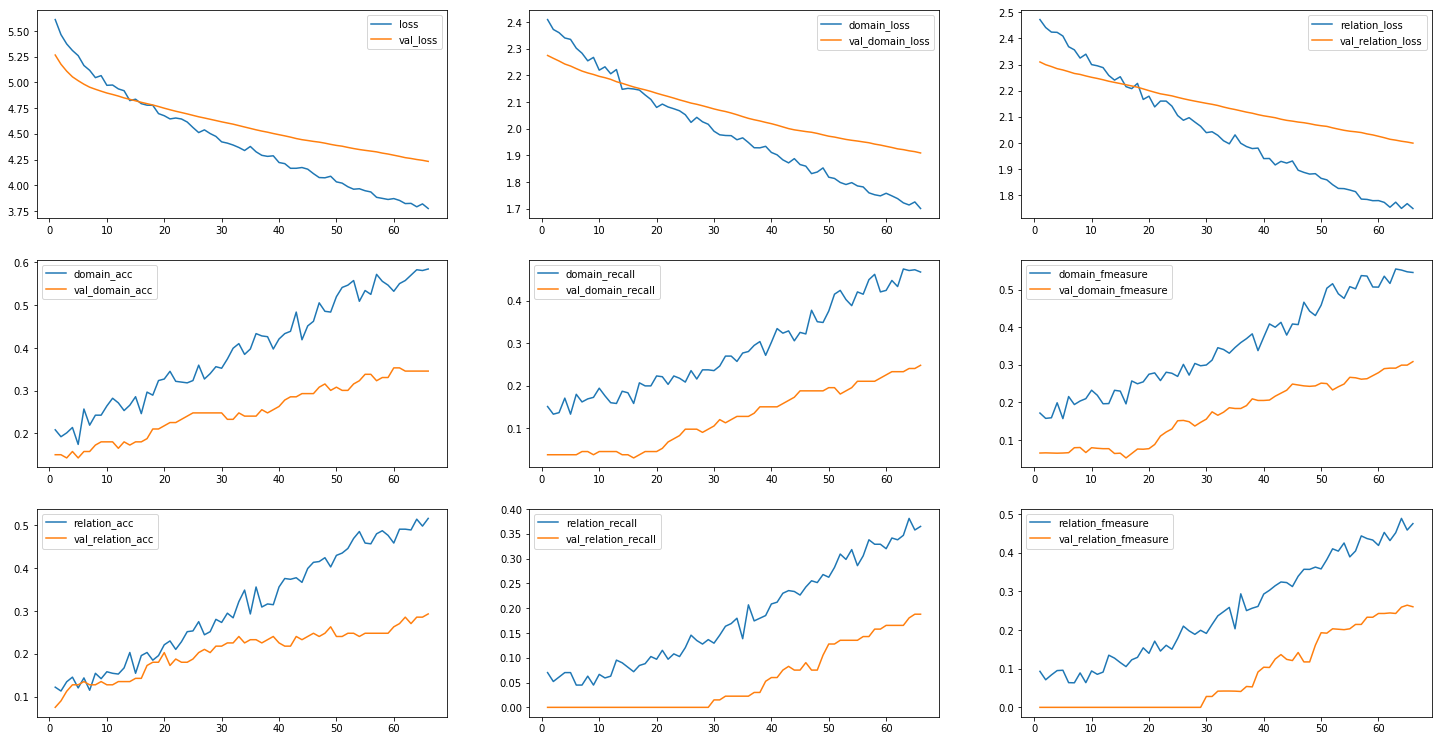

In [ ]:
model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(1.0 * n_train / batch_size),
    validation_data=val_generator,
    validation_steps=np.ceil(1.0 * n_val / val_batch_size),
    epochs=cache_epochs + epochs,
    initial_epoch=cache_epochs,
    callbacks=callbacks,
    verbose=0,
    max_queue_size=5,
    workers=4,
    class_weight=class_weight,
)

# Evaluation

In [ ]:
val_generator = val_datagen.flow(
    k_x_val, k_y_val, 
    maxlen=max_timestep, 
    output_cbk=process_labels, 
    batch_size=n_val,
    seed=SHARED_SEED,
    shuffle=False,
)

k_y_val_predicted = model.predict_generator(val_generator, steps=1)

decoded_prediction = decode_prediction(k_y_val_predicted, mode=output_mode)

In [ ]:
weighted = False
print('Macro{} metrics'.format('_weighted' if weighted else ''))

domain_is_present = 'domain' in decoded_prediction
if domain_is_present:
    if output_mode == 'domain':
        dom_stats = compute_stats(k_y_val, decoded_prediction['domain'], weighted=weighted)
        print_statistics(val_stats=dom_stats)
    else:
        dom_stats = compute_stats(relation_to_domain_vec(k_y_val), decoded_prediction['domain'], weighted=weighted)
        print_statistics(val_stats=dom_stats)

        dom_from_rel_stats = compute_stats(relation_to_domain_vec(k_y_val), relation_to_domain_vec(decoded_prediction['relation']), weighted=weighted)
        print_statistics(val_stats=dom_from_rel_stats)

relation_is_present = 'relation' in decoded_prediction
if relation_is_present:
    rel_stats = compute_stats(k_y_val,  decoded_prediction['relation'], weighted=weighted)
    print_statistics(val_stats=rel_stats)

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          digits=True,
                         ):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=60)
        plt.yticks(tick_marks, target_names)

    if digits:
        thresh = cm.max() / 1.5 if normalize else cm.max() / 2
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
#    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted label'.format(accuracy, misclass))
    plt.show()

In [ ]:
if domain_is_present:
    cm = dom_stats[1]
    plot_confusion_matrix(cm=cm, 
                          normalize    = True,
                          target_names = DOMAINS,
                          digits=True,
                          title='',
                          cmap='Reds')

In [ ]:
if relation_is_present:
    cm = rel_stats[1]
    plot_confusion_matrix(cm=cm, 
                          normalize    = True,
                          target_names = RELATIONS,
                          digits=True,
                          title='',                      
                          cmap='Reds')

# Model definition and graph

In [ ]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))